In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [4]:
print("train: %d" % x_train.shape[0])
print("val: %d" % x_val.shape[0])
print("test: %d" % x_test.shape[0])

train: 364
val: 91
test: 114


In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [7]:
from tqdm import tqdm

In [8]:
class DualLayer:
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.units = units
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
       
    def init_weights(self, x):
        self.w1 = np.ones((x.shape[1], self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0
        
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        hidden_to_err = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, hidden_to_err) / m
        b1_grad = np.sum(hidden_to_err, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_losses(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
     
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x)
        m = len(x)
        for i in tqdm(range(epochs)):
            z = self.forpass(x)
            a = self.activation(z)
            err = - (y - a)
            w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
            w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
            w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
            self.w1 -= self.lr * w1_grad
            self.b1 -= self.lr * b1_grad
            self.w2 -= self.lr * w2_grad
            self.b2 -= self.lr * b2_grad
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_losses(x_val, y_val)
            
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))    

In [9]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

100%|██████████| 20000/20000 [00:20<00:00, 984.83it/s]


0.978021978021978

In [10]:
import matplotlib.pyplot as plt

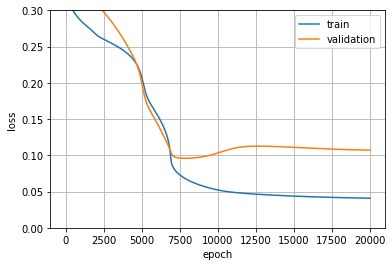

In [11]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

In [12]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, x):
        np.random.seed(seed=42)
        self.w1 = np.random.normal(0, 1, (x.shape[1], self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [13]:
random_init_net = RandomInitNetwork(l2=0.02)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

100%|██████████| 500/500 [00:00<00:00, 956.46it/s]


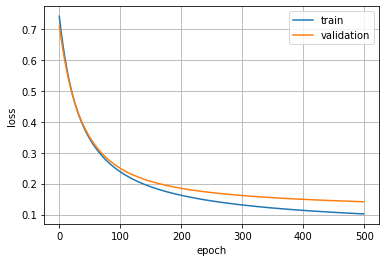

In [14]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

In [16]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32,learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x)
        np.random.seed(42)
        for i in tqdm(range(epochs)):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                m = len(x_batch)
                
                y_batch = y_batch.reshape(-1, 1)
                
                z = self.forpass(x_batch)
                a = self.activation(z)
                err = - (y_batch - a)

                w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x_batch, err)

                w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
                w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

                self.w1 -= self.lr * w1_grad
                self.b1 -= self.lr * b1_grad

                self.w2 -= self.lr * w2_grad
                self.b2 -= self.lr * b2_grad

                a = np.clip(a, 1e-10, 1-1e-10)

                loss += np.sum(- (y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
            
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_losses(x_val, y_val)
            
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_losses(self, x_val, y_val):
        z2 = self.forpass(x_val)
        a2 = self.activation(z2)
        a2 = np.clip(a2, 1e-10, 1-1e-10)
        val_loss = np.sum(- (y_val * np.log(a2) + (1 - y_val) * np.log(1 - a2)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [17]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

100%|██████████| 500/500 [00:02<00:00, 211.05it/s]


0.978021978021978

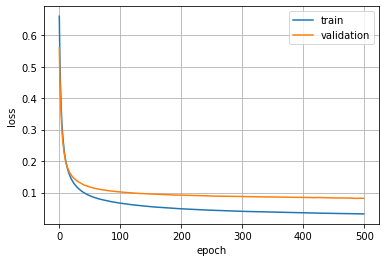

In [18]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

# Train with scikit-learn

In [9]:
from sklearn.neural_network import MLPClassifier

In [10]:
mlp = MLPClassifier(hidden_layer_sizes=(10,),
                    activation='logistic',
                    solver='sgd',
                    alpha=0.01,
                    batch_size=32,
                    learning_rate_init=0.1,
                    max_iter=500)

In [11]:
mlp.fit(x_train_scaled, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size=32,
              hidden_layer_sizes=(10,), learning_rate_init=0.1, max_iter=500,
              solver='sgd')

In [12]:
mlp.score(x_val_scaled, y_val)

0.989010989010989